In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import pandas as pd
import matplotlib
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt 
import numpy as np
import seaborn as sn
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets, metrics, model_selection, svm
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [12]:
df3 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/mergedBobAndMel.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (717,720,721,722,724,725) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:

#au= pd.concat([df3[' timestamp'], df3.iloc[:,-35:-18]], axis = 1)
dfo = df3.loc[:,df3.columns.str.contains('gaze|Elaborated')]
#df3 = df3.loc[:,df3.columns.str.contains('AU|Elaborated|Hypothesizing')]
dfo = dfo.fillna(0)
dfo = dfo.reset_index(drop=True)


In [14]:
dfo.head

<bound method NDFrame.head of         gaze_0_x   gaze_0_y  ...   gaze_angle_y  Elaborated
0       0.289805  -0.016923  ...         -0.013         0.0
1       0.292639  -0.023140  ...         -0.022         0.0
2       0.292457  -0.022910  ...         -0.022         0.0
3       0.290240  -0.021741  ...         -0.021         0.0
4       0.290315  -0.016937  ...         -0.016         0.0
...          ...        ...  ...            ...         ...
85176   0.000000   0.000000  ...          0.000         0.0
85177   0.000000   0.000000  ...          0.000         0.0
85178   0.000000   0.000000  ...          0.000         0.0
85179   0.000000   0.000000  ...          0.000         0.0
85180   0.000000   0.000000  ...          0.000         0.0

[85181 rows x 9 columns]>

From Wencheng's EDA, a scatterplot showing the directions of the intervewee's gaze throughout the dataset.

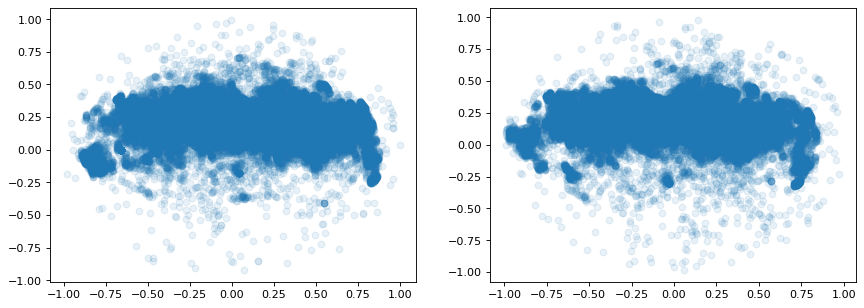

In [15]:
plt.figure(figsize=(13, 10), dpi=80)
plt.subplot(221)
plt.scatter(dfo[' gaze_0_x'], dfo[' gaze_0_y'], alpha=0.1)
plt.subplot(222)
plt.scatter(dfo[' gaze_1_x'], dfo[' gaze_1_y'], alpha=0.1)
plt.show()

It appears that the subject turned his head left and right quite often. Considering this is combined data from both Bob and Mel, it is likely that these datapoints show the two subjects turning to look at one another when answering a question. It will be interesting to see if the moments they turn are any indication of elaboration. [link text](https://)

In [16]:
pd.set_option("display.max_columns", None)
dfo.head

<bound method NDFrame.head of         gaze_0_x   gaze_0_y   gaze_0_z   gaze_1_x   gaze_1_y   gaze_1_z  \
0       0.289805  -0.016923  -0.956936   0.144923  -0.008608  -0.989405   
1       0.292639  -0.023140  -0.955943   0.147014  -0.019102  -0.988950   
2       0.292457  -0.022910  -0.956004   0.148692  -0.020111  -0.988679   
3       0.290240  -0.021741  -0.956707   0.146911  -0.019510  -0.988957   
4       0.290315  -0.016937  -0.956781   0.146740  -0.014432  -0.989070   
...          ...        ...        ...        ...        ...        ...   
85176   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
85177   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
85178   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
85179   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
85180   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

        gaze_angle_x   gaze_angle_y  Elaborated  
0              0.22

***XGBoost***

In [17]:
x = dfo.loc[:,dfo.columns.str.contains('gaze')]
y = dfo.loc[:,dfo.columns.str.contains('Elaborated')]
data_dmatrix = xgb.DMatrix(data=x,label=y)

In [18]:
for col in dfo.columns:
  print(col)

 gaze_0_x
 gaze_0_y
 gaze_0_z
 gaze_1_x
 gaze_1_y
 gaze_1_z
 gaze_angle_x
 gaze_angle_y
Elaborated


In [19]:
dfo = dfo.fillna(0)
x_train, x_test, y_train, y_test = train_test_split(dfo.drop(['Elaborated'], axis = 'columns'), dfo.Elaborated, test_size = 0.3)

In [20]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)
preds

[21:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.21456385, 0.17781705, 0.22255611, ..., 0.18696684, 0.17892566,
       0.18696684], dtype=float32)

In [21]:
for i in range(len(preds)):
  if preds[i] >= .28:
    preds[i] = 1
  else:
    preds[i] = 0
preds

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [22]:
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.12%


I adjusted the parameters for a 'elaborated' prediction to be a value >= 0.33 generated by the xgboost model. This produced a much higher accuracy predicting 1s for 'Elaborated', around 62%. Lowering the parameter increases the accuracy for 1s, but lowers it for 0s. 

Text(69.0, 0.5, 'Truth')

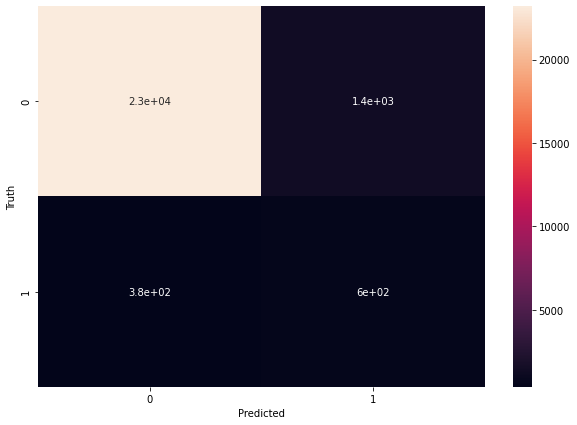

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

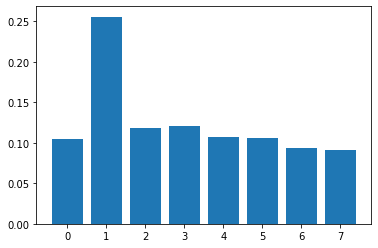

In [24]:
plt.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_)
plt.show()

In [25]:
for col in dfo.columns:
    print(col)

 gaze_0_x
 gaze_0_y
 gaze_0_z
 gaze_1_x
 gaze_1_y
 gaze_1_z
 gaze_angle_x
 gaze_angle_y
Elaborated


gaze_0_y is most **important**, seems to indicate that when the subject looks up or down is the best indicator of elaborated?

***RNN***


Since RNN can't take negative numbers, add 1 to all values to make the range [.5,2.5] instead of [-1.5,1]

In [26]:
x_train, x_test, y_train, y_test = train_test_split(dfo.drop(['Elaborated'], axis = 'columns'), dfo.Elaborated, test_size = 0.3)
f = lambda x: x + 1.5
x_train = x_train.applymap(f)
x_test = x_test.applymap(f)

In [27]:
x_train = pd.DataFrame(data = x_train)
x_train = x_train.fillna(0)
x_train = x_train.to_numpy()

x_train.shape

(59626, 8)

In [28]:
x_train = x_train.reshape(59626,8)

In [29]:
y_train = pd.DataFrame(data=y_train)
y_train = y_train.fillna(0)
y_train = y_train.to_numpy()
y_train = y_train.reshape(59626,1)

In [30]:
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(x_train, y_train)
fit.scores_


array([ 0.1252877 , 14.66029215, 10.99705386,  0.75189475,  8.87455683,
        8.00070583,  0.34639387, 15.07546846])

In [31]:
x_train=test.fit_transform(x_train, y_train)

In [32]:
y_train = pd.DataFrame(data = y_train)
y_train = y_train.values.reshape(59626)
print(y_train.shape)
print(x_test.shape)
print(x_train.shape)

(59626,)
(25555, 8)
(59626, 5)


In [33]:
x_train = pd.DataFrame(data = x_train)
x_train = x_train.values.reshape(59626,-1,1)

In [34]:
x_test = pd.DataFrame(data = x_test)
x_test = x_test.values.reshape(25555,-1,1)
print(x_test.shape)

(25555, 8, 1)


In [35]:
y_test = pd.DataFrame(data = y_test)

In [36]:
model = Sequential()

In [37]:
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
y_train = pd.DataFrame(data = y_train)
opt = model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [38]:
model.fit(x_train,
          y_train,
          epochs = 1,
          batch_size=5,
          validation_data=(x_test, y_test))

  936/11926 [=>............................] - ETA: 1:59 - loss: 0.0423 - accuracy: 0.0718

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict(x_test)
preds


In [ ]:
preds[1000]

In [ ]:
preds2 = []
for i in range(len(preds)):
  if preds[i][1] >= .1:
    preds2.append(1)
  else:
    preds2.append(0)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds2)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

This model is very bad for reasons explained in the paper

***RANDOM FOREST***

In [64]:
x_train, x_test, y_train, y_test = train_test_split(dfo.drop(['Elaborated'], axis = 'columns'), dfo.Elaborated, test_size = 0.3)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Text(69.0, 0.5, 'Truth')

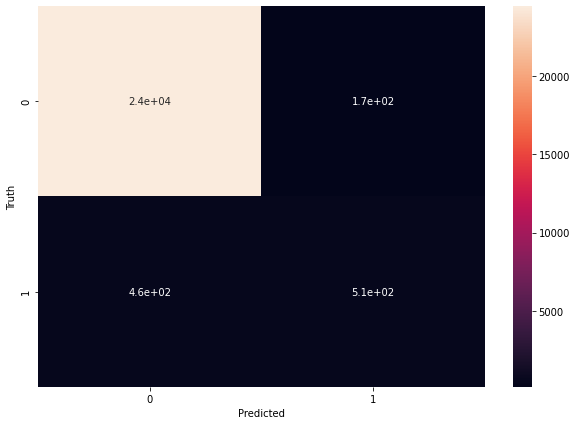

In [40]:
from sklearn.metrics import confusion_matrix
y_predicted = model.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

53% accurate predicting 1's and 99% accurate predicting 0s. Far more accurate than I anticipated. 

***Joint Attention with Random Forest***

In [70]:
dfn = df3.loc[:,df3.columns.str.contains('gaze_0_x|gaze_0_y|Elaborated')]
dfn = dfn.fillna(0)

In [71]:
x_train, x_test, y_train, y_test = train_test_split(dfn.drop(['Elaborated'], axis = 'columns'), dfn.Elaborated, test_size = 0.3)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Text(69.0, 0.5, 'Truth')

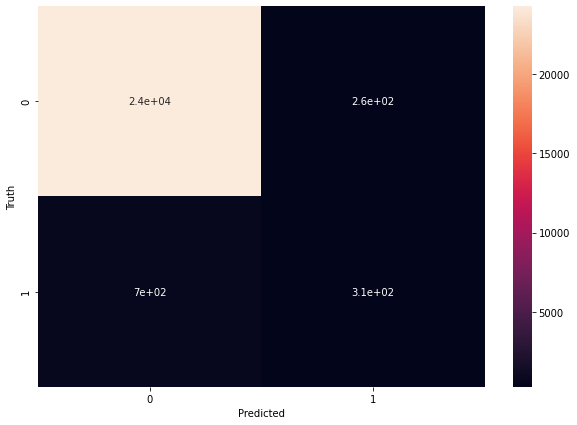

In [72]:
from sklearn.metrics import confusion_matrix
y_predicted = model.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')